In [3]:
#import dash
!pip install requests
!pip install psychrochart
!pip install pandas
!pip install -U ladybug-core
!pip install git+https://github.com/Yoshiki443/weather_parameters
import requests
import json
import csv
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import math as math

  Running command git clone -q https://github.com/Yoshiki443/weather_parameters 'C:\Users\81803\AppData\Local\Temp\pip-req-build-xv_u1hqr'


  Cloning https://github.com/Yoshiki443/weather_parameters to c:\users\81803\appdata\local\temp\pip-req-build-xv_u1hqr
  Resolved https://github.com/Yoshiki443/weather_parameters to commit ae2c9ed02f68968cb6ea0610d556f3c68bbc923e


C:\Users\81803\AppData\Local\Temp/ipykernel_35792/1990198614.py:10: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\81803\AppData\Local\Temp/ipykernel_35792/1990198614.py:11: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [90]:
#Jsonデータを読み込む

#JsonDataの中で、結果を算出
def getResultData(id):
    try:
        response = requests.get(f'https://oyster-app-8jboe.ondigitalocean.app/therb/{id}')
        data = json.loads(response.text)
        return data['data']
    except:
        throw('no id matches data in database')

#結果データをKeyごとにデータを変換
def dataFrameByKey(resultDataList,columnName):
    tempData = []
    columns=[]
    for resultData in resultDataList:
        df = convertToDataframe(resultData["results"])
        try:
            tempData.append(df[columnName])
            columns.append(resultData["roomId"])
        except:
            pass
    df=pd.concat(tempData,axis=1)
    df.columns = columns
    return df

#結果データをPandasで使えるようにする
def convertToDataframe(resultDict):
    columns = []
    rows = []
    for k,v in resultDict.items():
        columns.append(k)
        rows.append(v)
    #ここで、n行1列を1行n列に変換している(Pandasのデータ構造に合わせる為)
    transposedRows = np.array(rows).T
    df = pd.DataFrame(data = transposedRows, columns = columns) 
    df=df.set_index('time')
    df=df.astype('float32')
    return df

#結果データをKeyごとにデータを変換
#JsonDataの中で、各要素の面積を算出
def getAreaResultData(id):
    try:
        response = requests.get(f'https://oyster-app-8jboe.ondigitalocean.app/geometry/{id}')
        data = json.loads(response.text)
        return data
    except:
        throw('no id matches data in database')
        
#JsonDataの中で、各要素の物性値を算出
def getConstructResultData():
    try:
        response = requests.get('https://stingray-app-vgak2.ondigitalocean.app/envelopes')
        data = json.loads(response.text)
        return data
    except:
        throw('no id matches data in database')

In [81]:
#湿り空気線図を作るデータの為の関数
#配列を生成
def dfArray(df,roomId):
    df=df[roomId]
    array=[]
    for i in range(len(df.index)):
        array.append(df.iloc[i])
    return array

#平均外気温度を算出する
def Outdoorenvironmentalresults(id):
    ResultData=getResultData(id)
    tempdictdf=dataFrameByKey(ResultData,"temp")
    outdoordf=tempdictdf["outdoor"]
    meanTemperature=round(outdoordf.mean(),2)
    return meanTemperature

#気象ポテンシャルを評価する為の図式化を行う為の方程式
def PassiveMethodformula(method,meanTemperature):
    PassiveDict={"ActiveSolar":-1.9,"PassiveSolar":2.1,"InternalGain":6.6,"Winter":12.1,"Com1":14.1,"Com2":19.1,"Com3":21.1,"NaturalVentation":26.1}
    #Search=input("ActiveSolar,PassiveSolar,InternalGain,Winter,Com1,Com2,Com3,NaturalVentationから選択：")
    #NaturalVentation、Comだったら領域になるので注意
    SelectMethod=PassiveDict[str(method)]
    Value=SelectMethod+0.31*meanTemperature
    Value=round(Value,2)
    return Value

#図式化を行うための具体的な値
def PassiveMethodValue(id):
    ActiveSolar=PassiveMethodformula("ActiveSolar",Outdoorenvironmentalresults(id))
    PassiveSolar=PassiveMethodformula("PassiveSolar",Outdoorenvironmentalresults(id))
    InternalGain=PassiveMethodformula("InternalGain",Outdoorenvironmentalresults(id))
    NaturalVentation=PassiveMethodformula("NaturalVentation",Outdoorenvironmentalresults(id))
    Winter=PassiveMethodformula("Winter",Outdoorenvironmentalresults(id))
    Com1=PassiveMethodformula("Com1",Outdoorenvironmentalresults(id))
    Com2=PassiveMethodformula("Com2",Outdoorenvironmentalresults(id))
    Com3=PassiveMethodformula("Com3",Outdoorenvironmentalresults(id))
    ComHalf=(Com2+Com3)/2
    NaturalHalf=(Com3+NaturalVentation)/2
    Result={"NaturalHalf":NaturalHalf,"ComHalf":ComHalf,"ActiveSolar":ActiveSolar,"PassiveSolar":PassiveSolar,"InternalGain":InternalGain,
            "Winter":Winter,"Com1":Com1,"Com2":Com2,"Com3":Com3,"NaturalVentation":NaturalVentation}
    return Result

#野外のポテンシャルを図るためのZoneを生成
def OutdoorZone(id):
    result=PassiveMethodValue(id)
    #CreateZone
    zones_conf = {
        "zones":[{
                "zone_type": "dbt-rh",
                "style": {"edgecolor": [0, 0, 0, 1],
                          "facecolor": [1, 1, 1, 0.1],
                          "linewidth": 2,
                          "linestyle": "--"},
                "points_x": [result["InternalGain"], result["Winter"]],
                "points_y": [20, 80],
                "label": "InternalGain"
    },
                {
                "zone_type": "dbt-rh",
                "style": {"edgecolor": [0.275, 0.51, 0.71, 1],
                          "facecolor": [0.275, 0.51, 0.71, 0.1],
                          "linewidth": 2,
                          "linestyle": "--"},
                "points_x": [result["Winter"],result["Com1"]],
                "points_y": [20, 80],
                "label": "Winter"
    },
    {
                "zone_type": "dbt-rh",
                "style": {"edgecolor": [1.0, 1.0, 0.00, 1],
                          "facecolor": [1.0, 1.0, 0.00, 0.5],
                          "linewidth": 3,
                          "linestyle": "--"},
                "points_x": [result["Com1"], result["ComHalf"]],
                "points_y": [20, 80],
                "label": "Comfort"
    },
    {
                "zone_type": "dbt-rh",
                "style": {"edgecolor": [0.23, 0.70, 0.45, 1],
                          "facecolor": [0.23, 0.70, 0.45, 0.1],
                          "linewidth": 3,
                          "linestyle": "--"},
                "points_x": [result["Com1"],result["NaturalHalf"] ],
                "points_y": [20,80],
                "label": "NaturalVentation"
    } ]}
    return zones_conf

C:\Users\81803\anaconda3\lib\site-packages\psychrochart\chart.py:533: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = self.figure.gca(position=position)
C:\Users\81803\anaconda3\lib\site-packages\psychrochart\chart.py:533: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = self.figure.gca(position=position

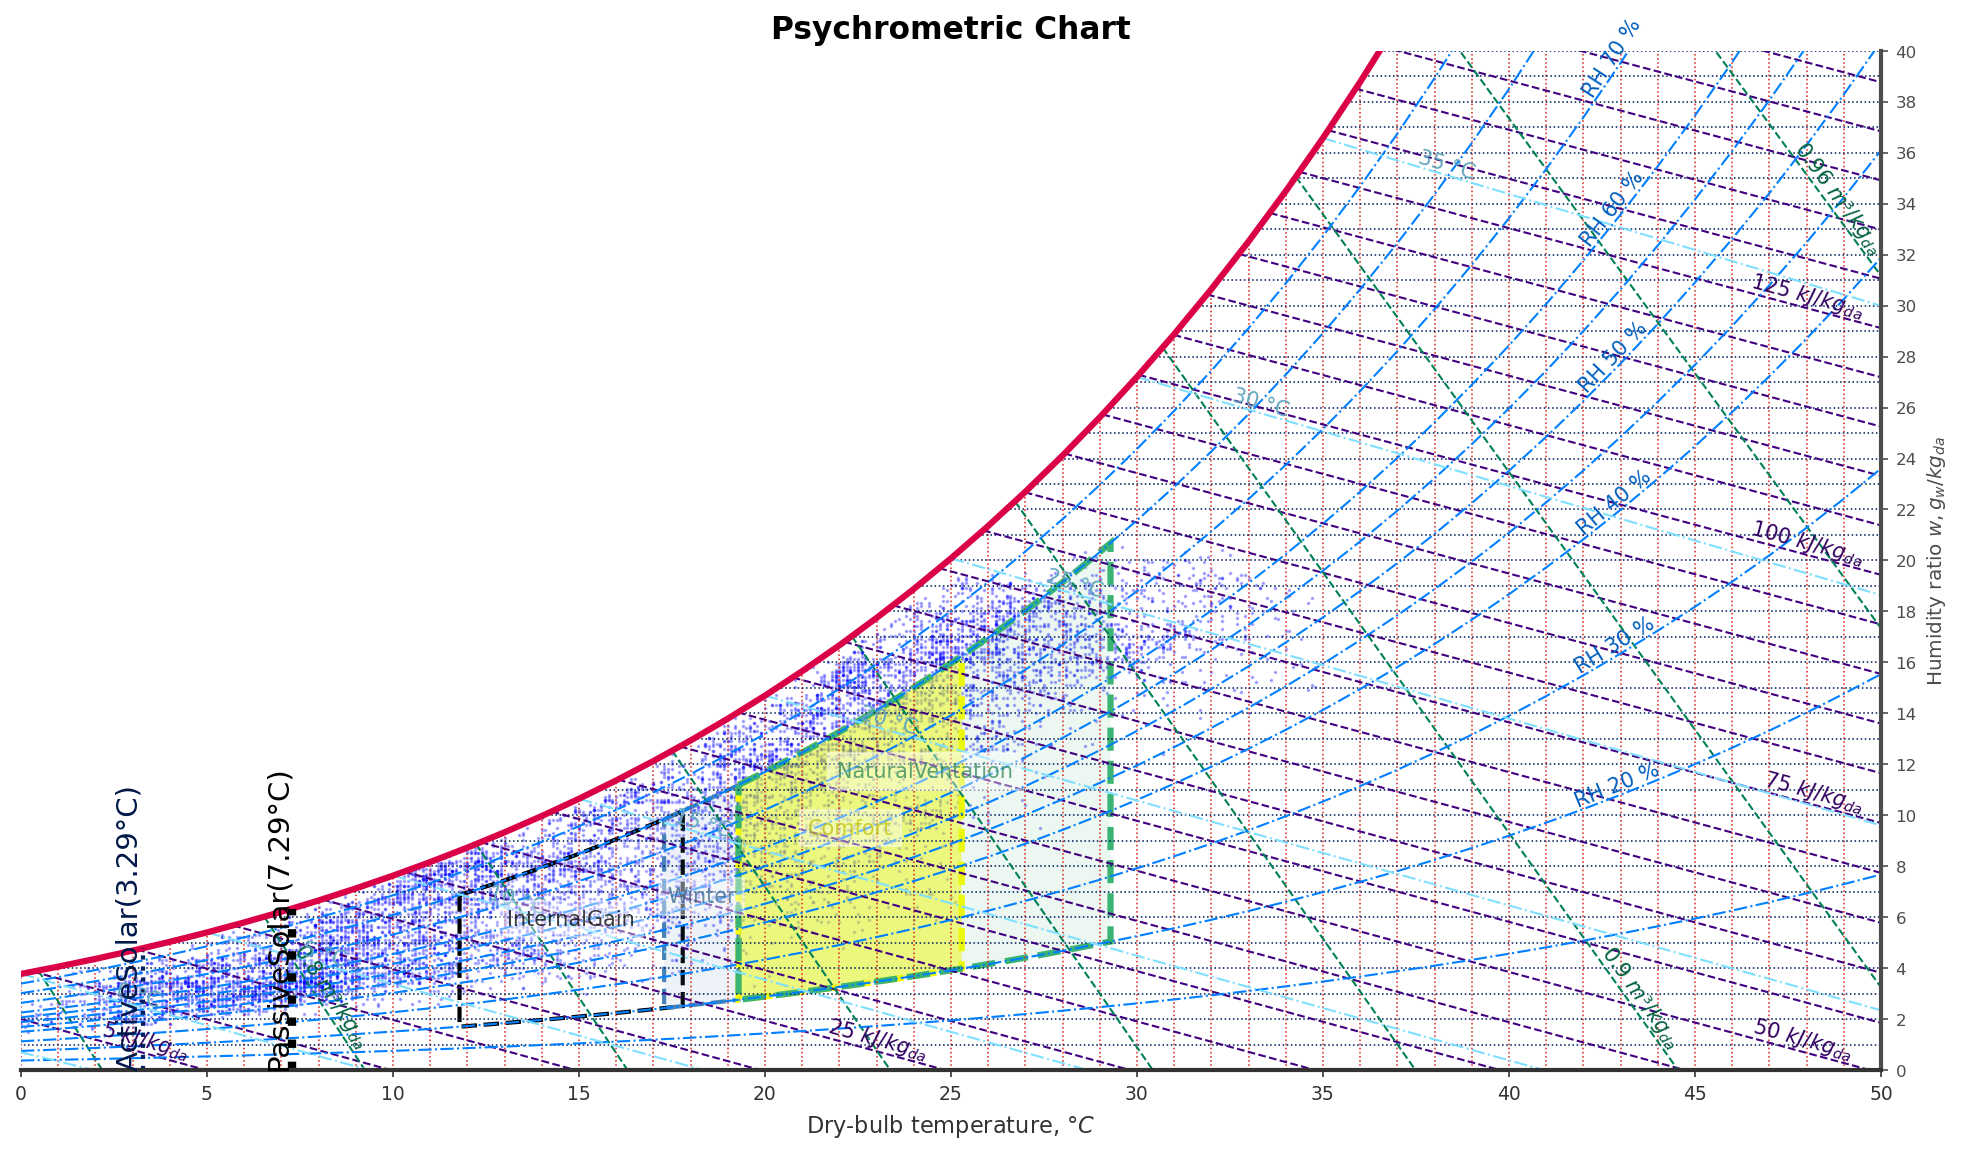

In [89]:
#EvaluateOutdoorPotencial
analysisArray=outdoorplotresults(9)
from psychrochart import PsychroChart
from psychrochart import load_zones
from psychrochart import load_config
config_style = load_config('default')
config_zone = load_zones()
config_zone['zones'].clear() # zoneリストの末尾のデータを削除
config_zone=OutdoorZone(12) #ここでidをチェンジ
chart = PsychroChart(config_style, config_zone)
ax = chart.plot()
# Add Vertical lines
ActiveSolar=PassiveMethodValue(12)["ActiveSolar"]
PassiveSolar=PassiveMethodValue(12)["PassiveSolar"]
ax = chart.plot()
points_style = {'s': 0.5, 'alpha': 0.3, 'color': 'blue'}
chart.plot_points_dbt_rh(analysisArray,scatter_style=points_style)
chart.plot_vertical_dry_bulb_temp_line(
    ActiveSolar, {"color": [0.0, 0.125, 0.376], "lw": 2, "ls": ':'},
    'ActiveSolar({}°C)'.format(ActiveSolar), ha='left', loc=0., fontsize=14)
chart.plot_vertical_dry_bulb_temp_line(
    PassiveSolar, {"color": [0.0, 0.0, 0.0], "lw": 4, "ls": ':'},
    'PassiveSolar({}°C)'.format(PassiveSolar), ha='left', loc=0., fontsize=14)
ax.get_figure()

C:\Users\81803\anaconda3\lib\site-packages\psychrochart\chart.py:533: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = self.figure.gca(position=position)


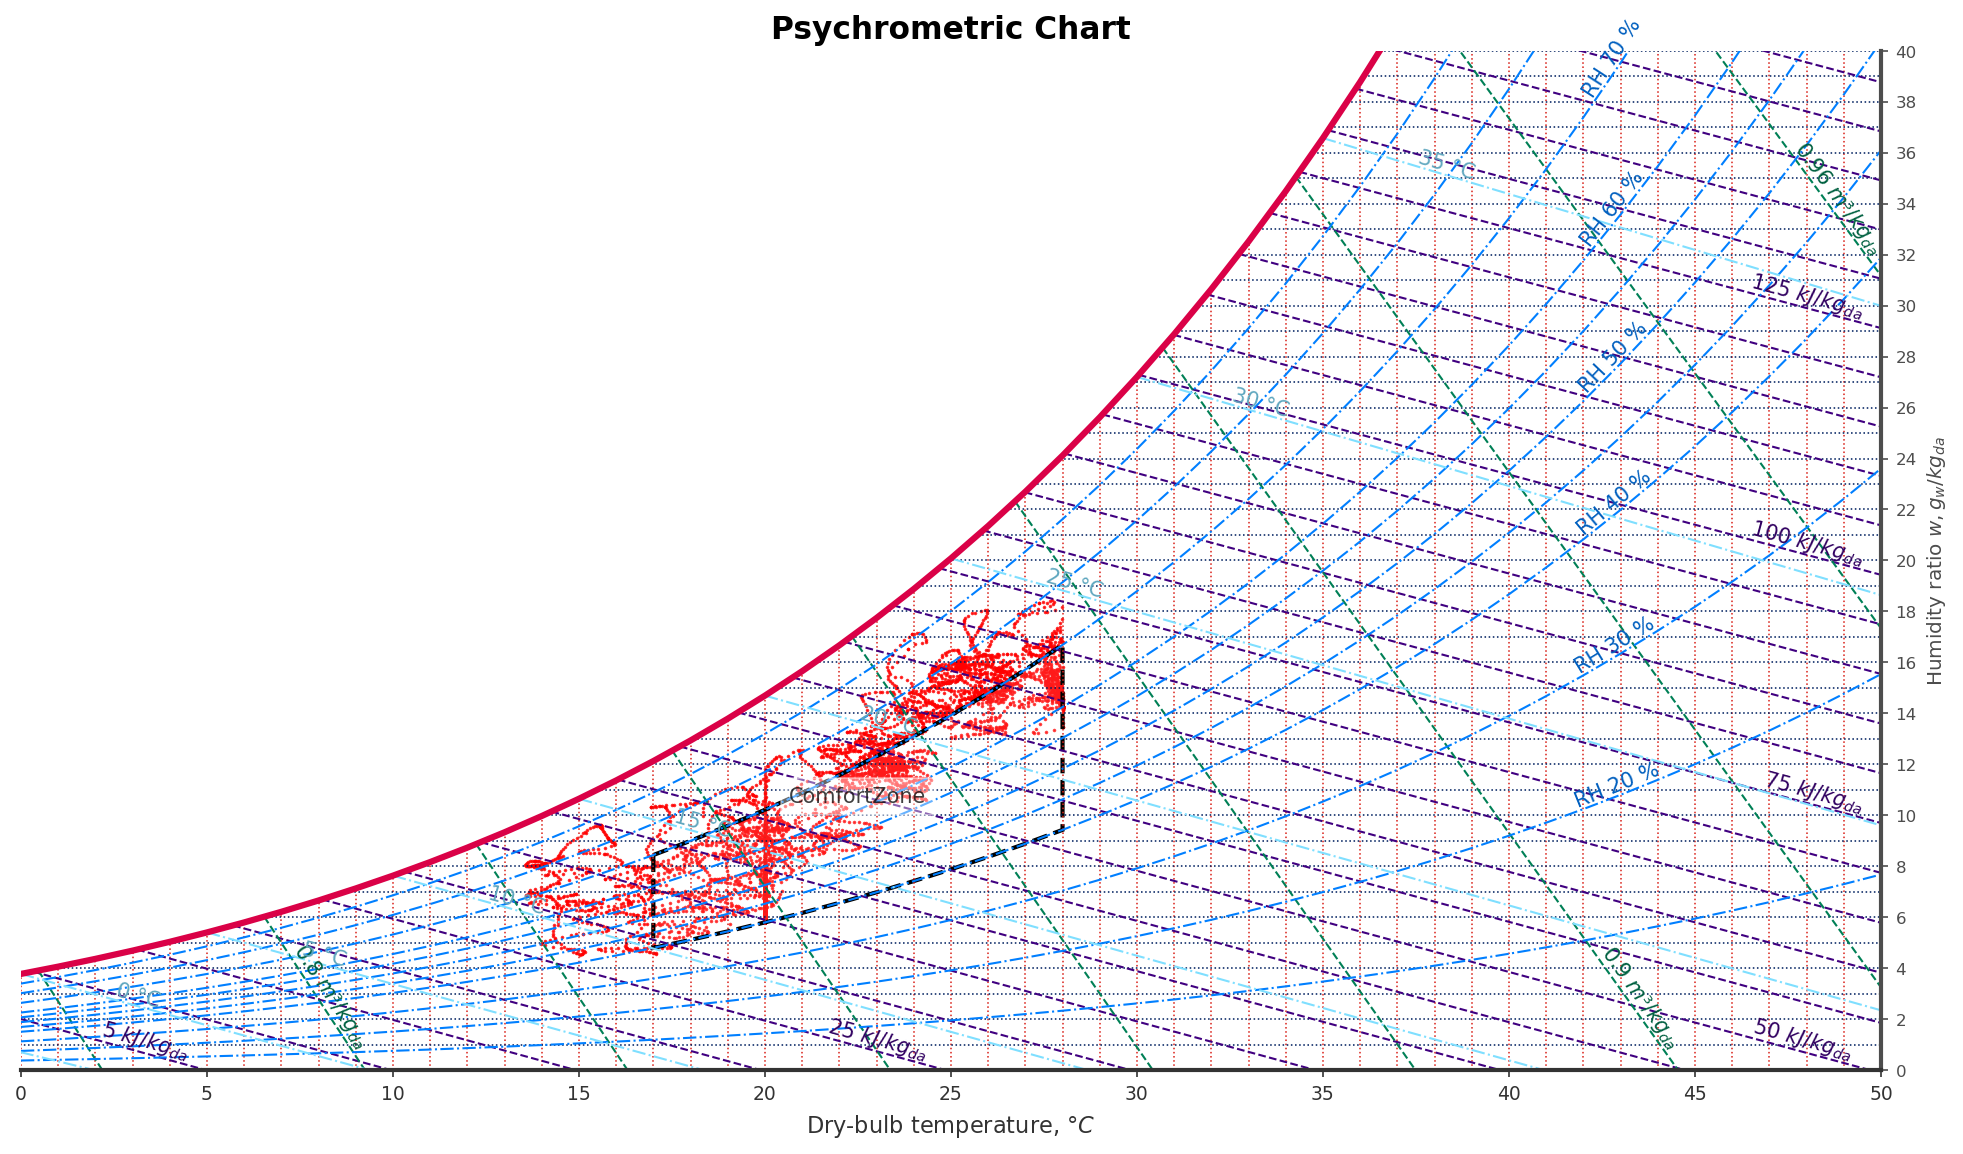

In [222]:
analysisArray=Indoorplotresults(8)
from psychrochart import PsychroChart
from psychrochart import load_zones
from psychrochart import load_config
config_style = load_config('default')
config_zone = load_zones()
config_zone['zones'].clear() # zoneリストの末尾のデータを削除
#CreateZone
zones_conf = {
    "zones":[{
            "zone_type": "dbt-rh",
            "style": {"edgecolor": [0, 0, 0, 1],
                      "facecolor": [1, 1, 1, 0.1],
                      "linewidth": 2,
                      "linestyle": "--"},
            "points_x": [17, 28],
            "points_y": [40, 70],
            "label": "ComfortZone"
}]}
config_zone=zones_conf
chart = PsychroChart(config_style, config_zone)
points_style = {'s': 0.5, 'alpha': 0.8, 'color': 'red'}
ax = chart.plot()
chart.plot_points_dbt_rh(analysisArray,scatter_style=points_style) #解析した結果はanalysisArray,屋外はpoints_array
ax.get_figure()

In [200]:
# for analysisArray in Indoorplotresults(10):#これが出来ない。(matplotlibで複数表示するように作ってないためだと思われる)
#     from psychrochart import PsychroChart
#     from psychrochart import load_zones
#     from psychrochart import load_config
#     config_style = load_config('default')
#     config_zone = load_zones()
#     config_zone['zones'].clear() # zoneリストの末尾のデータを削除
#     #CreateZone
#     zones_conf = {
#         "zones":[{
#                 "zone_type": "dbt-rh",
#                 "style": {"edgecolor": [0, 0, 0, 1],
#                           "facecolor": [1, 1, 1, 0.1],
#                           "linewidth": 2,
#                           "linestyle": "--"},
#                 "points_x": [17, 28],
#                 "points_y": [40, 70],
#                 "label": "ComfortZone"
#     }]}
#     config_zone=zones_conf
#     chart = PsychroChart(config_style, config_zone)
#     points_style = {'s': 0.5, 'alpha': 0.8, 'color': 'red'}
#     ax = chart.plot()
#     chart.plot_points_dbt_rh(analysisArray,scatter_style=points_style) #解析した結果はanalysisArray,屋外はpoints_array
#     ax.get_figure()

In [8]:
#解析結果の為の関数
#熱抵抗値の算出
def calcthermalresistance(getConstructResultData):
    Elements=['exteriorWall','interiorWall','floorCeiling','window','groundFloor',"roof"]
    ResultThermalResistance={}
    for element in Elements:
        ThermalResistanceElements=[]
        A2=ConstructResult["data"][0][element]["thickness"]
        for i in range(len(A2)): #A2の0はプロジェクトごとに変化すると思われる
            #explode conductivity
            Thickness=A2[i]/1000  #convert mm → m
            Conductivity=ConstructResult["data"][0][element]["materials"][i]["conductivity"]
            ResistanceElement=Thickness/Conductivity
            ThermalResistanceElements.append(ResistanceElement)
        ThermalResistance=round(np.sum(ThermalResistanceElements),3)
        ResultThermalResistance[element]=ThermalResistance
    return ResultThermalResistance

#熱貫流率の算出
def calctransmittance(getConstructResultData):
    Elements=['exteriorWall','interiorWall','floorCeiling','window','groundFloor']
    ThermalTransmittance={}
    for element in Elements:
        ThermalTransmittElement=getConstructResult["data"][0][element]["uvalue"]
        ThermalTransmittance[element]=ThermalTransmittElement
    return ThermalTransmittance

#外皮平均熱貫流率の算出
def calcUAvalue(ThermalTransmittance):
    Result=[]
    AllArea=[]
    for element in ThermalTransmittance.keys():
        Area=Arearesult["data"][0]['area'][element]
        AllArea.append(Area)
        Uvalue=ThermalTransmittance[element]
        Elements=Uvalue*Area
        Result.append(Elements)
    UA=sum(Result)/sum(AllArea)
    UA=round(UA,3)
    return UA

#室内環境基準を元にした温度、湿度の室内領域の％表示
def Indoorenvironmentalresults(id):
    ResultData=getResultData(id)
    tempdictdf=dataFrameByKey(ResultData,"temp")
    humiditydf=dataFrameByKey(ResultData,"relHumidity")
    Allresult=[]
    for roomId in tempdictdf.keys():
        IndoorResult={"roomId":{},"results":{}}
        Temp=tempdictdf[roomId]
        Humid=humiditydf[roomId]
        analysisArray = {'points_series_name': (Temp, Humid)}
        AcceptData = []
        ExccedaTemp=[]
        ExccedHumid=[]
        LowTemp=[]
        LowHumid=[]
        #AcceptData
        for i in range(len(Temp)):
            if 17<=Temp[i]<=28:
                if 40<=Humid[i]<=70:
                    AcceptData.append([Temp[i],Humid[i]])
        AnswerA=round((len(AcceptData)/len(Temp))*100,1)
        #ExccedaTemp
        for i in range(len(Temp)):
            if 28<Temp[i]:
                ExccedaTemp.append(Temp[i])
        AnswerET=round((len(ExccedaTemp)/len(Temp))*100,1)
        #LowTemp
        for i in range(len(Temp)):
            if Temp[i]<17:
                LowTemp.append(Temp[i])
        AnswerLT=round((len(LowTemp)/len(Temp))*100,1)
        #ExccedHumid
        for i in range(len(Humid)):
            if 70<Humid[i]:
                ExccedHumid.append(Humid[i])
        AnswerEH=round((len(ExccedHumid)/len(Temp))*100,1)
        #LowHumid
        for i in range(len(Humid)):
            if Humid[i]<40:
                LowHumid.append(Humid[i])
        AnswerLH=round((len(LowHumid)/len(Temp))*100,1)
        if roomId != "outdoor":
            IndoorResult["roomId"]=roomId
            IndoorResult["results"]["AcceptData"]=AnswerA
            IndoorResult["results"]["ExccedaTemp"]=AnswerET
            IndoorResult["results"]["LowTemp"]=AnswerLT
            IndoorResult["results"]["ExccedHumid"]=AnswerEH
            IndoorResult["results"]["LowHumid"]=AnswerLH
            Allresult.append(IndoorResult)
    return Allresult

#室内環境の温度湿度の結果(ポイントでプロットする為)
def Indoorplotresults(id):
    ResultData=getResultData(id)
    tempdictdf=dataFrameByKey(ResultData,"temp")
    humiditydf=dataFrameByKey(ResultData,"relHumidity")
    Allresult=[]
    for roomId in tempdictdf.keys():
        if roomId != "outdoor":
            Temp=dfArray(tempdictdf,roomId)
            Humid=dfArray(humiditydf,roomId)
            analysisArray = (Temp, Humid)
            points_array = {'points_series_name': analysisArray}
            Allresult.append(points_array)
    return Allresult

In [19]:
def Indoorplotresults(id):
    ResultData=getResultData(id)
    tempdictdf=dataFrameByKey(ResultData,"temp")
    humiditydf=dataFrameByKey(ResultData,"relHumidity")
    for roomId in tempdictdf.keys():
        if roomId != "outdoor":
            Temp=dfArray(tempdictdf,roomId)
            Humid=dfArray(humiditydf,roomId)
            analysisArray = (Temp, Humid)
            points_array = {'points_series_name': analysisArray}
    return points_array

def outdoorplotresults(id):
    ResultData=getResultData(id)
    tempdictdf=dataFrameByKey(ResultData,"temp")
    humiditydf=dataFrameByKey(ResultData,"relHumidity")
    for roomId in tempdictdf.keys():
        if roomId == "outdoor":
            Temp=dfArray(tempdictdf,roomId)
            Humid=dfArray(humiditydf,roomId)
            analysisArray = (Temp, Humid)
            points_array = {'points_series_name': analysisArray}
    return points_array

In [69]:
#屋外の自然換気の有効域の％
def EvalueatePassiveNatural(id):
    Outdoortemp=outdoorplotresults(id)["points_series_name"][0]
    Outdoorhumid=outdoorplotresults(id)["points_series_name"][1]
    a=[]
    result=PassiveMethodValue(id)
    for i in range(len(Outdoortemp)):
        if result["Com1"]<=Outdoortemp[i]<=result["NaturalHalf"]:
            if 20<=Outdoorhumid[i]<=90:
                a.append("True")
    Answer=round((len(a)/len(Outdoortemp))*100,1)
    return Answer

#屋外の快適性の有効域％
def EvalueatePassiveComfort(id):
    Outdoortemp=outdoorplotresults(id)["points_series_name"][0]
    Outdoorhumid=outdoorplotresults(id)["points_series_name"][1]
    a=[]
    result=PassiveMethodValue(id)
    for i in range(len(Outdoortemp)):
        if result["Com1"]<=Outdoortemp[i]<=result["ComHalf"]:
            if 20<=Outdoorhumid[i]<=90:
                a.append("True")
    Answer=round((len(a)/len(Outdoortemp))*100,1)
    return Answer
#屋外の冬季のの有効域％
def EvalueatePassiveWinter(id):
    Outdoortemp=outdoorplotresults(id)["points_series_name"][0]
    Outdoorhumid=outdoorplotresults(id)["points_series_name"][1]
    a=[]
    result=PassiveMethodValue(id)
    for i in range(len(Outdoortemp)):
        if result["Winter"]<=Outdoortemp[i]<=result["Com1"]:
            if 20<=Outdoorhumid[i]<=90:
                a.append("True")
    Answer=round((len(a)/len(Outdoortemp))*100,1)
    return Answer
#屋外の内部負荷の有効域％
def EvalueatePassiveInternalGain(id):
    Outdoortemp=outdoorplotresults(id)["points_series_name"][0]
    Outdoorhumid=outdoorplotresults(id)["points_series_name"][1]
    a=[]
    result=PassiveMethodValue(id)
    for i in range(len(Outdoortemp)):
        if result["InternalGain"]<=Outdoortemp[i]<=result["Winter"]:
            if 20<=Outdoorhumid[i]<=90:
                a.append("True")
    Answer=round((len(a)/len(Outdoortemp))*100,1)
    return Answer
#屋外のパッシブソーラーゲイン手法の有効域％
def EvalueatePassiveSolarGain(id):
    Outdoortemp=outdoorplotresults(id)["points_series_name"][0]
    a=[]
    result=PassiveMethodValue(id)
    for i in (Outdoortemp):
        if result["PassiveSolar"]<=i:
            a.append("True")
    Answer=round((len(a)/len(Outdoortemp))*100,1)
    return Answer
def OutdoorPassiveData(id):
    A=EvalueatePassiveNatural(id)
    B=EvalueatePassiveComfort(id)
    C=EvalueatePassiveWinter(id)
    D=EvalueatePassiveInternalGain(id)
    E=EvalueatePassiveSolarGain(id)
    Data=[A,B,C,D,E]
    return Data

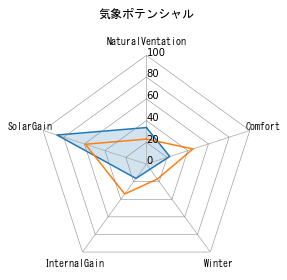

In [84]:
#屋外の気象データの分析
#!/usr/bin/env python
# -*- coding: utf-8 -*-
values=OutdoorPassiveData(11)
avevalues = np.array([23,45,17,34,59])#ここは解析を回したのちに
radar_values = np.concatenate([values, [values[0]]])
averadar_values = np.concatenate([avevalues, [avevalues[0]]])
labels = ["NaturalVentation","Comfort","Winter","InternalGain","SolarGain"]
# プロットする角度を生成する。
angles = np.linspace(0, 2 * np.pi, len(labels) + 1, endpoint=True)
# メモリ軸の生成
rgrids = [0, 20, 40, 60, 80, 100]


fig = plt.figure(facecolor="w")
# 極座標でaxを作成
ax = fig.add_subplot(1, 1, 1, polar=True)
# レーダーチャートの線を引く
ax.plot(angles, radar_values)
ax.plot(angles, averadar_values)
#　レーダーチャートの内側を塗りつぶす
ax.fill(angles, radar_values, alpha=0.2)
# 項目ラベルの表示
ax.set_thetagrids(angles[:-1] * 180 / np.pi, labels,fontname="MS Gothic")
# 円形の目盛線を消す
ax.set_rgrids([])
# 一番外側の円を消す
ax.spines['polar'].set_visible(False)
# 始点を上(北)に変更
ax.set_theta_zero_location("N")
# 時計回りに変更(デフォルトの逆回り)
ax.set_theta_direction(-1)

# 多角形の目盛線を引く
for grid_value in rgrids:
    grid_values = [grid_value] * (len(labels)+1)
    ax.plot(angles, grid_values, color="gray",  linewidth=0.5)

# メモリの値を表示する
for t in rgrids:
    # xが偏角、yが絶対値でテキストの表示場所が指定される
    ax.text(x=0, y=t, s=t)

# rの範囲を指定
ax.set_rlim([min(rgrids), max(rgrids)])

ax.set_title("気象ポテンシャル", pad=20,fontname="MS Gothic")
plt.show()
#print(values)